# Denoising Spectrograms Network

In [1]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML
import math

## 1. Functions

In [236]:
def get_mels_list(path_to_spectrograms_dir,number_of_mels):
    import os
    clean_mels_list = [] 
    noisy_mels_list = []

    path_to_train_clean_spectrograms_dir_subfolder = ''
    path_to_train_noisy_spectrograms_dir_subfolder = ''

    import os
    i=1
    for entry in os.scandir(path_to_train_clean_spectrograms_dir):
        if entry.is_dir():
            #print(i)
            #print(entry.name)
            path_to_train_clean_spectrograms_dir_subfolder = path_to_train_clean_spectrograms_dir + '/' + entry.name
            path_to_train_noisy_spectrograms_dir_subfolder = path_to_train_noisy_spectrograms_dir + '/' + entry.name

            #print(path_to_train_clean_spectrograms_dir_subfolder)
            #print(path_to_train_noisy_spectrograms_dir_subfolder)
            #print("------------------------------------------------")
            for subentry in os.scandir(entry.path):
                path_to_train_clean_spectrogram_file = path_to_train_clean_spectrograms_dir_subfolder + '/' + subentry.name
                path_to_train_noisy_spectrogram_file = path_to_train_noisy_spectrograms_dir_subfolder + '/' + subentry.name
                #print(path_to_train_clean_spectrogram_file)
                #print(path_to_train_noisy_spectrogram_file)
                clean_mel = get_mel(path_to_train_clean_spectrogram_file)
                noisy_mel = get_mel(path_to_train_noisy_spectrogram_file)
                clean_mels_list.append(clean_mel)
                noisy_mels_list.append(noisy_mel)
                
                i+=1
        if i>=number_of_mels:
            break

    return clean_mels_list, noisy_mels_list

In [3]:
def get_mel(full_file_path):
    raw = np.load(full_file_path)
    mel = np.array(raw).astype(np.float64).transpose()
    
    return mel

In [4]:
def get_mel_part_from_full_mel(mel, rng_from, rng_to):
    mel_drv = []

    for m in mel:
        mel_drv.append(m[rng_from:rng_to])

    mel_drv = np.array(mel_drv)

    return mel_drv

In [5]:
def get_mel_parts_list(mel, n_parts):
    
    mels_parts = []

    for p in range(0,n_parts):
        rng_from = p * part_length 
        rng_to = rng_from + part_length
        #print(str(p) + " " + str(rng_from) + " " + str(rng_to))
        mel_part = get_mel_part_from_full_mel(mel, rng_from, rng_to)
        mels_parts.append(mel_part)
        
    return mels_parts

In [6]:
def get_parts_of_clean_noise_mel(clean_mel,noisy_mel,part_length):
    
    s_length = len(clean_mel[0])
    n_parts = math.trunc(s_length/part_length)
    clean_mel_parts_list = get_mel_parts_list(clean_mel, n_parts)
    noisy_mel_parts_list = get_mel_parts_list(noisy_mel, n_parts)
    
    return clean_mel_parts_list,noisy_mel_parts_list

In [65]:
def get_parts_of_mel_for_predicting(mel,part_length):
    
    s_length = len(mel[0])
    n_parts = math.trunc(s_length/part_length)
    mel_parts_list = get_mel_parts_list(mel, n_parts)
    
    last_mel_part_length = len(mel[0])%part_length
    last_mel_part = mel[:,-last_mel_part_length]
    
    
    return mel_parts_list,last_mel_part

In [7]:
def show_clean_and_noisy_parts(clean_mel_parts,noisy_mel_parts):
    i=1
    for c_p,c_n in zip(clean_mel_parts,noisy_mel_parts):
        print(i)
        plt.imshow(c_p)
        plt.show()
        plt.imshow(c_n)
        plt.show()
        i+=1

In [8]:
def count_items(_list):
    d = {}
    for item in _list:
        if item in d:
            d[item] = d.get(item)+1
        else:
            d[item] = 1

    for k,v in d.items():
        print(str(k)+':'+str(v))

In [9]:
def reshape_arr_1(arr):
    x1 = np.array(arr)
    x = x1.reshape(x1.shape[0], x1.shape[1] * x1.shape[2])
    return x

In [10]:
def concatenate_arrays(_list):
    x_arr = np.zeros(8000).reshape(1,-1)
    #print(x_arr.shape)

    for x in _list:
        x1 = np.array(x)
     #   print(x1.shape)
        x_arr = np.concatenate((x_arr, x1), axis=0)
        
    return x_arr

In [11]:
def get_processed_data(path_to_train_clean_spectrograms_dir,number_of_mels,part_length):
    
    clean_mels_list, noisy_mels_list = get_mels_list(path_to_train_clean_spectrograms_dir,number_of_mels)
    
    clean_mels_parts_lists = []
    noisy_mels_parts_lists = []    

    for clean_mel, noisy_mel in zip(clean_mels_list, noisy_mels_list):
        print(str(len(clean_mel[0])) + ' ' + str(len(noisy_mel[0])))
        clean_mel_parts_list,noisy_mel_parts_list = get_parts_of_clean_noise_mel(clean_mel,noisy_mel,part_length)
        clean_mels_parts_lists.append(clean_mel_parts_list)
        noisy_mels_parts_lists.append(noisy_mel_parts_list)        
        
    x_list = []
    y_list = []

    for clean_mel_parts,noisy_mel_parts in zip(clean_mels_parts_lists,noisy_mels_parts_lists):
        if len(clean_mel_parts) !=0 or len(noisy_mel_parts) !=0:
            x_list.append(reshape_arr_1(noisy_mel_parts))
            y_list.append(reshape_arr_1(clean_mel_parts))
            
    X_train = concatenate_arrays(x_list)
    y_train = concatenate_arrays(y_list)

    print(X_train.shape)
    print(y_train.shape)
    
    return X_train,y_train

In [12]:
def save_array_to_file(data,name):
    
    # save numpy array as csv file
    from numpy import asarray
    from numpy import savetxt
    # define data
    data = asarray(data)
    # save to csv file
    savetxt(name+'.txt', data, delimiter=',')    
    

In [13]:
def load_from_array(name):
    # load numpy array from csv file
    from numpy import loadtxt
    # load array
    data = loadtxt(name+'.csv', delimiter=',')
    # print the array
    #print(data)
    return data

In [14]:
def get_training_stats(autoencoder_train_stats, epochs_num):
    loss = autoencoder_train_stats.history['loss']
    val_loss = autoencoder_train_stats.history['val_loss']
    epochs_arr = range(1, epochs_num + 1)
    plt.figure()
    plt.plot(epochs_arr, loss, 'b', label='Training loss')
    plt.plot(epochs_arr, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [15]:
def save_in_audio(noisy,clean,predicted):

    import numpy as np
    from scipy.io.wavfile import write

    data = noisy
    scaled = np.int16(data/np.max(np.abs(data)) * 32767)
    write('.\\predicted\\noisy.wav', 8000, scaled)

    data = clean
    scaled = np.int16(data/np.max(np.abs(data)) * 32767)
    write('.\\predicted\\clean.wav', 8000, scaled)

    data = predicted
    scaled = np.int16(data/np.max(np.abs(data)) * 32767)
    write('.\\predicted\\pred.wav', 8000, scaled)

In [222]:
def make_prediction(model, clean, noisy):
    
    #print('Noisy')
    plt.plot(noisy)

    #print('Clean')
    plt.plot(clean)

    #print('Predicted')
    pred = predict(model,noisy)
    plt.plot(pred)
    
    return noisy, clean, pred

In [17]:
def predict(model,sample):
    xx= np.array(sample)
    xx1 = xx.reshape(1,-1)
    pred = model.predict(xx1)[0]
    
    return pred

In [18]:
def get_scaler_min_max(dataset):
    from sklearn.preprocessing import MinMaxScaler
    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    return scaler

In [149]:
def make_predicted_parts_list(mel_parts_list):
    
    predicted_parts_list = []
    parts_arr = reshape_arr_1(mel_parts_list)
    for part in parts_arr:
        predicted_part = predict(autoencoder,part)
        predicted_parts_list.append(predicted_part)
        
    return predicted_parts_list

In [190]:
def reshape_predicted_part_back_to_mel_list(predicted_parts, part_length):

    predicted_parts_mel_list = []
    for predicted_part in predicted_parts:
        #print(len(predicted_part))
        predicted_part_reshaped = np.array(predicted_part).reshape(int(8000/part_length), part_length)
        predicted_parts_mel_list.append(predicted_part_reshaped)

    return predicted_parts_mel_list

In [212]:
def reconstruct_mel_from_predicted_parts(predicted_parts_mel_list):
    arr_c = np.zeros(0)
    
    for p in predicted_parts_mel_list:
        arr_c = np.concatenate((arr_c, p), axis=None)
        mel_arr = arr_c.reshape(80,int(arr_c.shape[0]/80))
    
    
    return mel_arr

## 2. Data preprocessing for training

### 2.1 Preparing training set

In [19]:
root_dir = "./"

path_to_train_clean_spectrograms_dir = root_dir + "/train/train/clean/"
path_to_train_noisy_spectrograms_dir = root_dir + "/train/train/noisy/"

files_batch = 3000
part_length= 100

In [20]:
X_train,y_train = get_processed_data(path_to_train_clean_spectrograms_dir,files_batch,part_length)

1
21
45
65
73
95
112
121
141
157
173
189
203
212
229
244
260
280
301
314
327
331
347
357
368
381
398
410
425
435
443
462
478
486
499
515
529
546
563
584
600
606
623
638
657
680
690
696
720
722
740
751
762
777
791
811
830
850
861
871
881
890
904
922
932
949
968
988
1004
1021
1040
1053
1074
1090
1103
1120
1126
1151
1173
1191
1203
1224
1239
1256
1275
1288
1298
1302
1312
1325
1347
1367
1373
1375
1388
1400
1416
1429
1455
1472
1490
1499
1516
1525
1541
1552
1559
1571
1597
1613
1626
1649
1655
1670
1681
1698
1714
1727
1747
1761
1783
1800
1819
1830
1839
1853
1870
1885
1900
1918
1935
1953
1965
1982
1991
2017
2033
2041
2045
2063
2084
2090
2103
2124
2139
2159
2174
2187
2208
2227
2249
2257
2279
2293
2314
2336
2364
2378
2397
2419
2432
2448
2460
2483
2497
2508
2525
2538
2547
2555
2560
2574
2592
2612
2636
2656
2665
2685
2708
2718
2731
2747
2764
2771
2783
2800
2818
2836
2858
2877
2898
2915
2928
2938
2956
2968
2972
2986
2996
966 966
658 658
414 414
974 974
872 872
911 911
972 972
905 905
1041 1041
860 86

864 864
1022 1022
1006 1006
551 551
495 495
960 960
857 857
699 699
611 611
916 916
992 992
871 871
278 278
811 811
962 962
251 251
989 989
905 905
740 740
1013 1013
1011 1011
960 960
921 921
971 971
872 872
994 994
996 996
743 743
949 949
618 618
899 899
990 990
617 617
868 868
140 140
234 234
934 934
900 900
938 938
730 730
957 957
806 806
554 554
688 688
185 185
214 214
518 518
734 734
811 811
323 323
926 926
685 685
1014 1014
926 926
1025 1025
473 473
827 827
928 928
822 822
457 457
661 661
436 436
147 147
794 794
926 926
991 991
627 627
673 673
894 894
820 820
186 186
688 688
895 895
936 936
414 414
952 952
775 775
949 949
840 840
699 699
975 975
737 737
807 807
971 971
908 908
961 961
877 877
974 974
985 985
950 950
999 999
1041 1041
619 619
915 915
825 825
868 868
819 819
802 802
887 887
934 934
865 865
982 982
422 422
810 810
944 944
918 918
953 953
925 925
942 942
983 983
609 609
915 915
1049 1049
810 810
967 967
942 942
207 207
900 900
569 569
941 941
1018 1018
812 812
734 73

832 832
231 231
873 873
846 846
151 151
399 399
155 155
635 635
1044 1044
578 578
992 992
262 262
291 291
541 541
973 973
1033 1033
945 945
940 940
988 988
828 828
972 972
871 871
562 562
735 735
987 987
853 853
815 815
798 798
777 777
916 916
762 762
957 957
878 878
178 178
278 278
945 945
981 981
825 825
1008 1008
700 700
871 871
888 888
970 970
865 865
600 600
996 996
981 981
978 978
925 925
889 889
646 646
713 713
654 654
961 961
826 826
403 403
997 997
889 889
861 861
791 791
954 954
895 895
982 982
821 821
623 623
873 873
802 802
977 977
851 851
941 941
248 248
1006 1006
973 973
925 925
792 792
801 801
994 994
845 845
823 823
1007 1007
676 676
934 934
641 641
891 891
1061 1061
872 872
919 919
941 941
828 828
889 889
932 932
862 862
763 763
714 714
406 406
552 552
974 974
991 991
661 661
971 971
884 884
949 949
887 887
962 962
999 999
888 888
962 962
653 653
280 280
491 491
976 976
1003 1003
900 900
508 508
936 936
900 900
176 176
674 674
974 974
641 641
999 999
875 875
876 876
63

(21085, 8000)
(21085, 8000)


### 2.2 Preparing validation dataset

In [21]:
root_dir = "./"

path_to_val_clean_spectrograms_dir = root_dir + "/val/val/clean/"
path_to_val_noisy_spectrograms_dir = root_dir + "/val/val/noisy/"

files_batch =2000
part_length= 100

In [22]:
X_val,y_val = get_processed_data(path_to_val_clean_spectrograms_dir,files_batch,part_length)

1
21
45
65
73
95
112
121
141
157
173
189
203
212
229
244
260
280
301
314
327
331
347
357
368
381
398
410
425
435
443
462
478
486
499
515
529
546
563
584
600
606
623
638
657
680
690
696
720
722
740
751
762
777
791
811
830
850
861
871
881
890
904
922
932
949
968
988
1004
1021
1040
1053
1074
1090
1103
1120
1126
1151
1173
1191
1203
1224
1239
1256
1275
1288
1298
1302
1312
1325
1347
1367
1373
1375
1388
1400
1416
1429
1455
1472
1490
1499
1516
1525
1541
1552
1559
1571
1597
1613
1626
1649
1655
1670
1681
1698
1714
1727
1747
1761
1783
1800
1819
1830
1839
1853
1870
1885
1900
1918
1935
1953
1965
1982
1991
966 966
658 658
414 414
974 974
872 872
911 911
972 972
905 905
1041 1041
860 860
901 901
401 401
862 862
940 940
887 887
572 572
719 719
963 963
927 927
992 992
773 773
977 977
889 889
1032 1032
919 919
908 908
164 164
1017 1017
400 400
387 387
707 707
461 461
886 886
206 206
469 469
206 206
1021 1021
749 749
942 942
547 547
934 934
167 167
349 349
557 557
941 941
821 821
541 541
323 323
775 775


554 554
688 688
185 185
214 214
518 518
734 734
811 811
323 323
926 926
685 685
1014 1014
926 926
1025 1025
473 473
827 827
928 928
822 822
457 457
661 661
436 436
147 147
794 794
926 926
991 991
627 627
673 673
894 894
820 820
186 186
688 688
895 895
936 936
414 414
952 952
775 775
949 949
840 840
699 699
975 975
737 737
807 807
971 971
908 908
961 961
877 877
974 974
985 985
950 950
999 999
1041 1041
619 619
915 915
825 825
868 868
819 819
802 802
887 887
934 934
865 865
982 982
422 422
810 810
944 944
918 918
953 953
925 925
942 942
983 983
609 609
915 915
1049 1049
810 810
967 967
942 942
207 207
900 900
569 569
941 941
1018 1018
812 812
734 734
920 920
179 179
1028 1028
334 334
992 992
810 810
733 733
882 882
995 995
374 374
193 193
886 886
901 901
393 393
959 959
417 417
339 339
210 210
884 884
422 422
576 576
565 565
903 903
931 931
457 457
968 968
179 179
360 360
492 492
663 663
612 612
897 897
1007 1007
977 977
317 317
836 836
911 911
183 183
926 926
949 949
1006 1006
840 840


(14107, 8000)
(14107, 8000)


## 3. Building Neural Networks Autoencoders

In [25]:
#Imports

%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML 
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import keras
from tensorflow.keras.models import load_model

### 3.1. Building Artificial Neural Network Autoencoder

In [34]:
# Fit regression DNN model.
print("Creating/Training neural network")
autoencoder = Sequential()
autoencoder.add(Dense(200, input_dim=X_train.shape[1], activation='relu'))
autoencoder.add(Dense(100, activation='relu'))
autoencoder.add(Dense(200, activation='relu'))
autoencoder.add(Dense(X_train.shape[1])) # Multiple output neurons
autoencoder.compile(loss='mean_squared_error', optimizer='adam')

Creating/Training neural network


In [35]:
batch_size =128
epochs = 50

In [36]:
autoencoder_train_stats = autoencoder.fit(X_train, y_train
                                    , batch_size=batch_size,epochs=epochs,verbose=1
                                    , validation_data=(X_val, y_val))
print("Neural network trained")

Epoch 1/50
165/165 [==============================] - 16s 99ms/step - loss: 0.1176 - val_loss: 0.0954
Epoch 2/50
165/165 [==============================] - 15s 92ms/step - loss: 0.0927 - val_loss: 0.0868
Epoch 3/50
165/165 [==============================] - 15s 92ms/step - loss: 0.0858 - val_loss: 0.0849
Epoch 4/50
165/165 [==============================] - 17s 100ms/step - loss: 0.0822 - val_loss: 0.0792
Epoch 5/50
165/165 [==============================] - 14s 86ms/step - loss: 0.0792 - val_loss: 0.0767
Epoch 6/50
165/165 [==============================] - 16s 96ms/step - loss: 0.0777 - val_loss: 0.0745
Epoch 7/50
165/165 [==============================] - 17s 105ms/step - loss: 0.0759 - val_loss: 0.0721
Epoch 8/50
165/165 [==============================] - 16s 100ms/step - loss: 0.0752 - val_loss: 0.0726
Epoch 9/50
165/165 [==============================] - 14s 84ms/step - loss: 0.0740 - val_loss: 0.0704
Epoch 10/50
165/165 [==============================] - 15s 92ms/step - loss: 0.

In [37]:
#Save model
autoencoder.save('denoiser.h5')

In [38]:
#Load model
autoencoder = load_model('denoiser.h5')

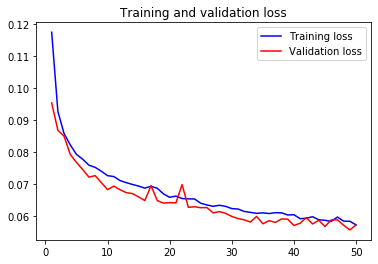

In [39]:
get_training_stats(autoencoder_train_stats, epochs)

## 4. Predict Clean Sound

### Ex-1

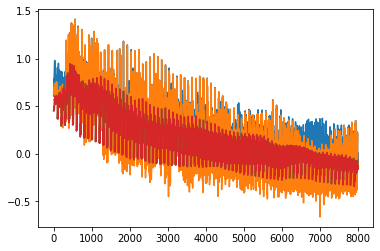

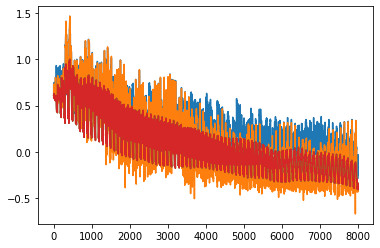

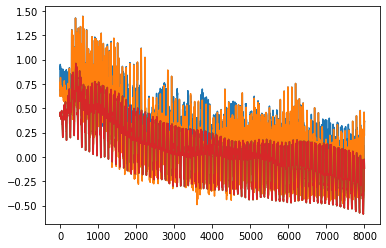

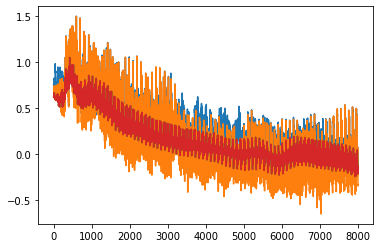

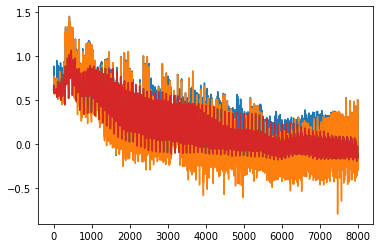

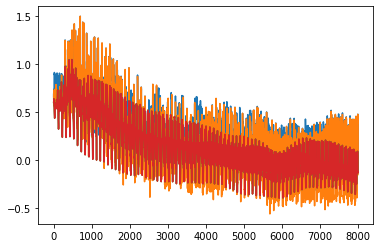

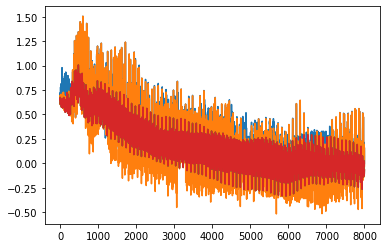

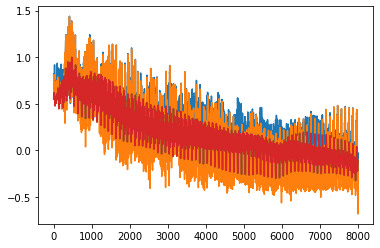

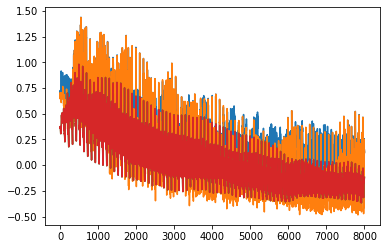

In [223]:
for noisy, clean in zip(X_val[1:10], y_val[1:10]):
    noisy, clean, predicted = make_prediction(autoencoder,clean, noisy)
    plt.plot(predicted)
    plt.show()
    save_in_audio(noisy,clean,predicted)

In [238]:
number_of_mels = 2000
predicted_mels_list= []
clean_mels_list, noisy_mels_list = get_mels_list(path_to_train_clean_spectrograms_dir,number_of_mels)

for clean_mel, noisy_mel in  zip(clean_mels_list[:], noisy_mels_list[:]):
    
        mel_parts_list,last_mel_part = get_parts_of_mel_for_predicting(noisy_mel,part_length)
        
        predicted_parts_list = make_predicted_parts_list(mel_parts_list)
        predicted_parts_mel_list = reshape_predicted_part_back_to_mel_list(predicted_parts_list, part_length)
        
        reconstructed_mel_from_predicted_parts = reconstruct_mel_from_predicted_parts(predicted_parts_mel_list)
        
        #print(noisy_mel.shape)
        #plt.imshow(noisy_mel)
        
        #print(reconstructed_mel_from_predicted_parts.shape)
        #plt.imshow(reconstructed_mel_from_predicted_parts)
        predicted_mels_list.append(reconstructed_mel_from_predicted_parts)
        
print("List of predicted mels length: {0}".format(len(predicted_mels_list)))

List of predicted mels length: 2016
